In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
dataset_path = '/content/drive/MyDrive/mll final/Root'

In [3]:
print("Dataset Path:", dataset_path)
print("\nFolder structure:")
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        print(f"{class_name} → {num_images} images")

Dataset Path: /content/drive/MyDrive/mll final/Root

Folder structure:
Almond → 184 images
Brazil Nuts → 144 images
Cashew → 240 images
Macademia → 99 images
Hazelnuts → 166 images
Peanut → 242 images
Pistachio → 299 images
Walnuts → 117 images
Thai Peanut → 136 images
Vietnamian Cashew → 115 images


/tmp/ipython-input-1547982745.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Class', y='Count', data=df, palette='viridis')


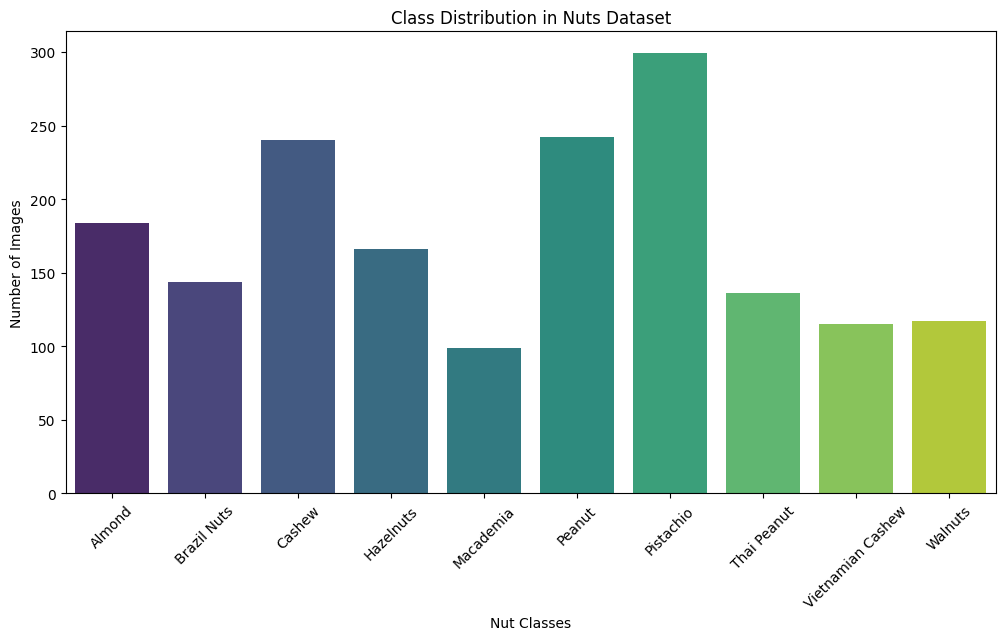

Total Image: 1742


In [4]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Counts
classes = []
counts = []
for class_name in sorted(os.listdir(dataset_path)):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        classes.append(class_name)
        counts.append(num_images)

# DataFrame
df = pd.DataFrame({'Class': classes, 'Count': counts})

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Class', y='Count', data=df, palette='viridis')
plt.title('Class Distribution in Nuts Dataset')
plt.xlabel('Nut Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.savefig('/content/class_distribution.png')
plt.show()

print("Total Image:", sum(counts))


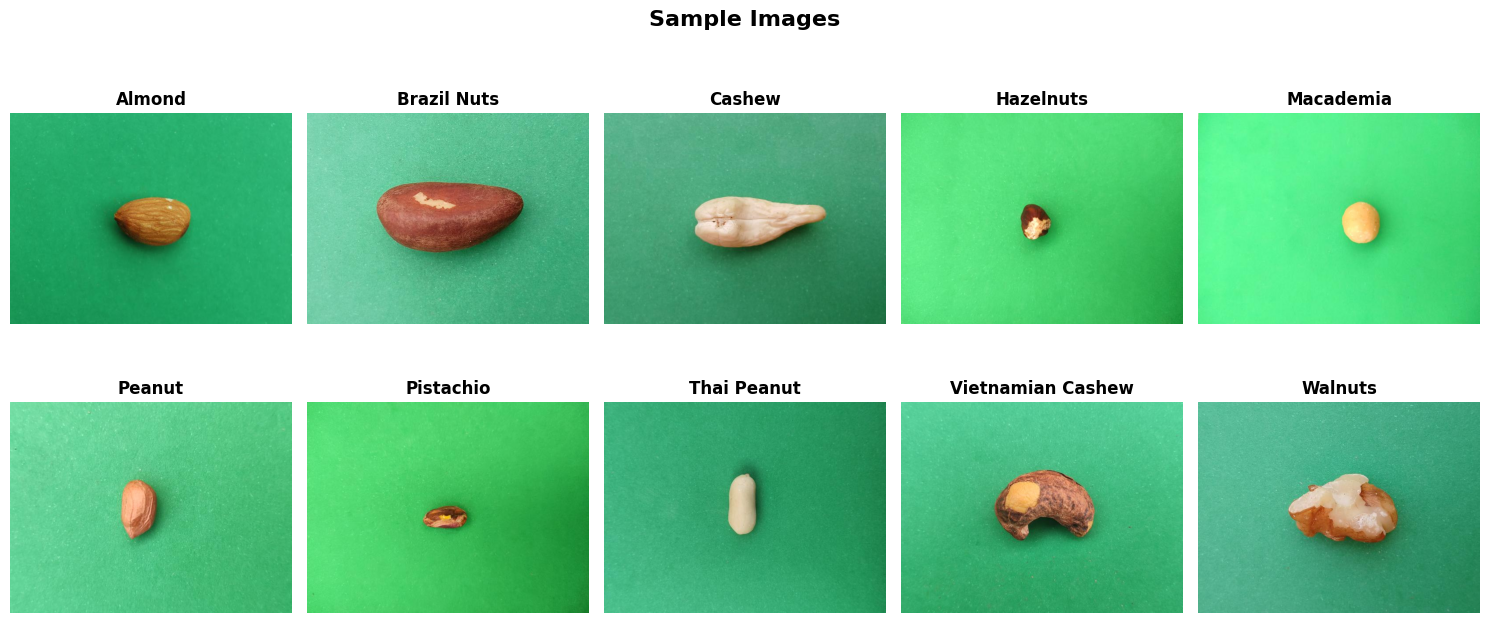

In [5]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import random


class_names = sorted([d for d in os.listdir(dataset_path)
                     if os.path.isdir(os.path.join(dataset_path, d))])


fig, axes = plt.subplots(2, 5, figsize=(15, 7))
axes = axes.ravel()

for i, class_name in enumerate(class_names):
    class_folder = os.path.join(dataset_path, class_name)
    img_files = os.listdir(class_folder)
    random_img = random.choice(img_files)
    img_path = os.path.join(class_folder, random_img)

    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].set_title(class_name, fontsize=12, fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Sample Images', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/sample_images.png', dpi=300, bbox_inches='tight')
plt.show()


In [6]:

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


print("GPU Available: ", tf.config.list_physical_devices('GPU'))

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Custom CNN

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Custom CNN running on: {device}")


Custom CNN running on: cuda


In [8]:
#Architecture
class CustomNutCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomNutCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 112

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 56

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 28

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 14
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512 * 14 * 14, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import numpy as np
import random
import os

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image size and Transforms
img_size = 224

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(img_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_full_ds = datasets.ImageFolder(dataset_path, transform=train_transform)
val_full_ds = datasets.ImageFolder(dataset_path, transform=val_test_transform)
test_full_ds = datasets.ImageFolder(dataset_path, transform=val_test_transform)


class_names = train_full_ds.classes
num_classes = len(class_names)
print(f"Total classes: {num_classes} → {class_names}")

# Split indices for train/val/test
total_size = len(train_full_ds)
train_size = int(0.80 * total_size)
val_size   = int(0.10 * total_size)
test_size  = total_size - train_size - val_size

# Perform the split on indices, not the datasets directly
indices = list(range(total_size))
random.seed(42) #
random.shuffle(indices)

train_indices = indices[:train_size]
val_indices = indices[train_size : train_size + val_size]
test_indices = indices[train_size + val_size :]

# Create Subset objects
train_dataset = Subset(train_full_ds, train_indices)
val_dataset   = Subset(val_full_ds,   val_indices)
test_dataset  = Subset(test_full_ds,  test_indices)

# DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train  samples: {len(train_dataset)}")
print(f"Val   samples: {len(val_dataset)}")
print(f"Test  samples: {len(test_dataset)}")

# model initialization
model = CustomNutCNN(num_classes=num_classes).to(device) # Use dynamically determined num_classes
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)

best_acc = 0.0
for epoch in range(12):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/12"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, pred = outputs.max(1)
        total += labels.size(0)
        correct += pred.eq(labels).sum().item()

    train_acc = 100. * correct / total

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, pred = outputs.max(1)
            total += labels.size(0)
            correct += pred.eq(labels).sum().item()

    val_acc = 100. * correct / total
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), '/content/custom_model.pth')
        print("Custom Model Saved!")

print(f"\nCustom CNN Training Complete!")
print(f"Best Validation Accuracy: {best_acc:.2f}%")

Total classes: 10 → ['Almond', 'Brazil Nuts', 'Cashew', 'Hazelnuts', 'Macademia', 'Peanut', 'Pistachio', 'Thai Peanut', 'Vietnamian Cashew', 'Walnuts']
Train  samples: 1393
Val   samples: 174
Test  samples: 175


Epoch 1/12: 100%|██████████| 44/44 [06:43<00:00,  9.18s/it]


Epoch 1 | Train Acc: 15.79% | Val Acc: 29.31%
Custom Model Saved!


Epoch 2/12: 100%|██████████| 44/44 [00:17<00:00,  2.46it/s]


Epoch 2 | Train Acc: 22.47% | Val Acc: 32.18%
Custom Model Saved!


Epoch 3/12: 100%|██████████| 44/44 [00:18<00:00,  2.39it/s]


Epoch 3 | Train Acc: 30.37% | Val Acc: 46.55%
Custom Model Saved!


Epoch 4/12: 100%|██████████| 44/44 [00:18<00:00,  2.38it/s]


Epoch 4 | Train Acc: 40.78% | Val Acc: 50.00%
Custom Model Saved!


Epoch 5/12: 100%|██████████| 44/44 [00:18<00:00,  2.40it/s]


Epoch 5 | Train Acc: 45.23% | Val Acc: 55.75%
Custom Model Saved!


Epoch 6/12: 100%|██████████| 44/44 [00:17<00:00,  2.45it/s]


Epoch 6 | Train Acc: 46.59% | Val Acc: 60.92%
Custom Model Saved!


Epoch 7/12: 100%|██████████| 44/44 [00:18<00:00,  2.38it/s]


Epoch 7 | Train Acc: 46.02% | Val Acc: 73.56%
Custom Model Saved!


Epoch 8/12: 100%|██████████| 44/44 [00:18<00:00,  2.41it/s]


Epoch 8 | Train Acc: 51.54% | Val Acc: 78.16%
Custom Model Saved!


Epoch 9/12: 100%|██████████| 44/44 [00:17<00:00,  2.46it/s]


Epoch 9 | Train Acc: 51.47% | Val Acc: 55.75%


Epoch 10/12: 100%|██████████| 44/44 [00:18<00:00,  2.40it/s]


Epoch 10 | Train Acc: 49.46% | Val Acc: 70.11%


Epoch 11/12: 100%|██████████| 44/44 [00:17<00:00,  2.46it/s]


Epoch 11 | Train Acc: 52.26% | Val Acc: 68.97%


Epoch 12/12: 100%|██████████| 44/44 [00:18<00:00,  2.37it/s]


Epoch 12 | Train Acc: 55.92% | Val Acc: 75.86%

Custom CNN Training Complete!
Best Validation Accuracy: 78.16%


In [10]:
import torch
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = CustomNutCNN(num_classes=10).to(device)
model.load_state_dict(torch.load('/content/custom_model.pth')) # Corrected filename
model.eval()


criterion = nn.CrossEntropyLoss()

# test
def test_epoch(model, loader, criterion, device):
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = running_loss / len(loader)
    test_acc = 100. * correct / total
    return test_loss, test_acc


test_loss, test_acc = test_epoch(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")

Testing: 100%|██████████| 6/6 [00:59<00:00,  9.95s/it]

Test Loss: 0.8448 | Test Accuracy: 71.43%


# ResNet50 model


In [11]:
# ImageDataGenerator-augmentation for train, only rescale for val/test
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3  # 70% train, 30% val+test
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=42
)

val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=42
)


Found 1224 images belonging to 10 classes.
Found 518 images belonging to 10 classes.


In [12]:
# ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)  # 10 classes

resnet_model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Compile
resnet_model.compile(optimizer=Adam(learning_rate=0.001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

# Model summary
resnet_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,114,826 (91.99 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [13]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
import time


In [14]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ResNet50 pretrained
model = models.resnet50(pretrained=True)

Using device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 126MB/s]


In [15]:
# freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# define num_classes here for self-contained execution
num_classes = 10

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

Using device: cuda
Total classes: 10 → ['Almond', 'Brazil Nuts', 'Cashew', 'Hazelnuts', 'Macademia', 'Peanut', 'Pistachio', 'Thai Peanut', 'Vietnamian Cashew', 'Walnuts']
Train  samples: 1393
Val   samples: 174
Test  samples: 175
Training start



Epoch 1/7
Train Loss: 1.7851 | Train Acc: 40.34%
Val   Loss: 0.9870 | Val   Acc: 83.91%
Best model saved!


Epoch 2/7
Train Loss: 1.0145 | Train Acc: 75.95%
Val   Loss: 0.5552 | Val   Acc: 89.08%
Best model saved!


Epoch 3/7
Train Loss: 0.7550 | Train Acc: 81.55%
Val   Loss: 0.3793 | Val   Acc: 94.25%
Best model saved!


Epoch 4/7
Train Loss: 0.6458 | Train Acc: 84.06%
Val   Loss: 0.2921 | Val   Acc: 95.40%
Best model saved!


Epoch 5/7
Train Loss: 0.5387 | Train Acc: 86.43%
Val   Loss: 0.2455 | Val   Acc: 97.13%
Best model saved!


Epoch 6/7
Train Loss: 0.5191 | Train Acc: 85.50%
Val   Loss: 0.2224 | Val   Acc: 95.40%


Epoch 7/7
Train Loss: 0.4783 | Train Acc: 86.58%
Val   Loss: 0.1910 | Val   Acc: 95.40%
Best Validation Accuracy: 97.13%


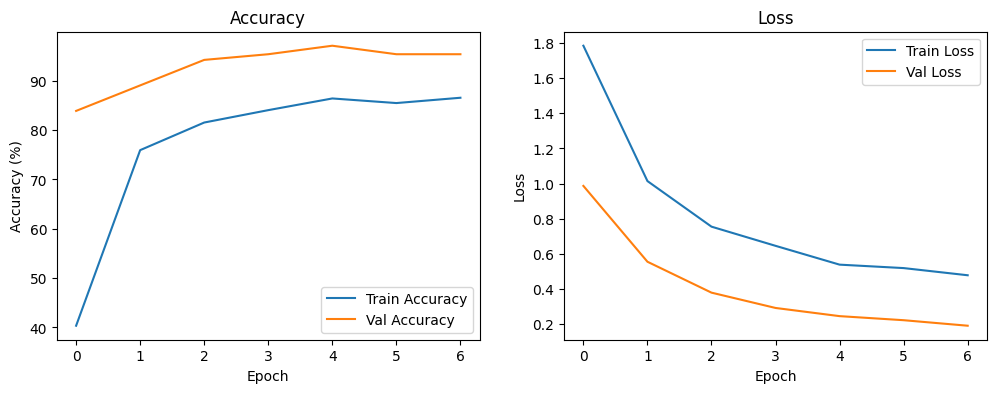

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import numpy as np
import random
import os



# Reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Image size and Transforms
img_size = 224

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(img_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_full_ds = datasets.ImageFolder(dataset_path, transform=train_transform)
val_full_ds = datasets.ImageFolder(dataset_path, transform=val_test_transform)
test_full_ds = datasets.ImageFolder(dataset_path, transform=val_test_transform)


class_names = train_full_ds.classes
num_classes = len(class_names)
print(f"Total classes: {num_classes} → {class_names}")

# Split indices for train/val/test
total_size = len(train_full_ds)
train_size = int(0.80 * total_size)
val_size   = int(0.10 * total_size)
test_size  = total_size - train_size - val_size

# Perform the split on indices, not the datasets directly
indices = list(range(total_size))
random.seed(42) #
random.shuffle(indices)

train_indices = indices[:train_size]
val_indices = indices[train_size : train_size + val_size]
test_indices = indices[train_size + val_size :]


train_dataset = Subset(train_full_ds, train_indices)
val_dataset   = Subset(val_full_ds,   val_indices)
test_dataset  = Subset(test_full_ds,  test_indices)

# DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train  samples: {len(train_dataset)}")
print(f"Val   samples: {len(val_dataset)}")
print(f"Test  samples: {len(test_dataset)}")

# ResNet50 model setup
model = models.resnet50(pretrained=True) #load

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Replace the last fully
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

# Loss + Optimizer + Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Validation function
def eval_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


epochs = 7
best_val_acc = 0.0
print("Training start\n")

# History lists for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = eval_epoch(model, val_loader, criterion, device)

    scheduler.step()

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), '/content/best_model.pth')
        print("Best model saved!")

print(f"Best Validation Accuracy: {best_val_acc:.2f}%")

# Plot accuracy & loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.savefig('/content/accuracy_plot.png')

plt.subplot(1,2,2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/loss_plot.png')
plt.show()

Testing: 100%|██████████| 6/6 [00:01<00:00,  3.14it/s]


<Figure size 1200x1000 with 0 Axes>

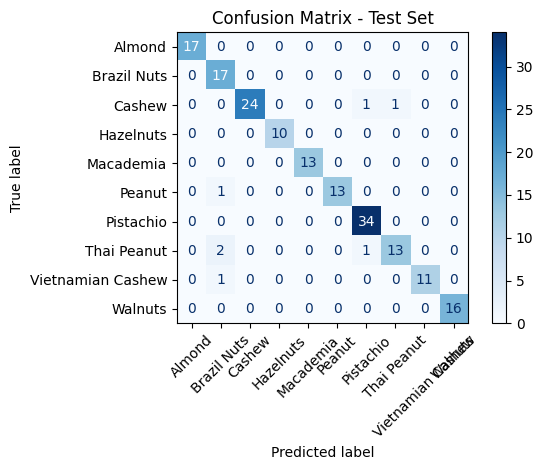

Test Loss: 0.2375 | Test Acc: 96.00%


In [17]:

import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# load
model.load_state_dict(torch.load('/content/best_model.pth'))
model.eval()

# Test function
def test_model(model, loader, criterion, device, class_names):
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = running_loss / len(loader)
    test_acc = 100. * correct / total

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    plt.figure(figsize=(12, 10))
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title('Confusion Matrix - Test Set')
    plt.tight_layout()
    plt.savefig('/content/confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

# Run test
test_model(model, test_loader, criterion, device, class_names)


Overall Accuracy: 0.9600 (96.00%)

Per-class Precision, Recall, F1-score:
                   precision    recall  f1-score   support

           Almond     1.0000    1.0000    1.0000        17
      Brazil Nuts     0.8095    1.0000    0.8947        17
           Cashew     1.0000    0.9231    0.9600        26
        Hazelnuts     1.0000    1.0000    1.0000        10
        Macademia     1.0000    1.0000    1.0000        13
           Peanut     1.0000    0.9286    0.9630        14
        Pistachio     0.9444    1.0000    0.9714        34
      Thai Peanut     0.9286    0.8125    0.8667        16
Vietnamian Cashew     1.0000    0.9167    0.9565        12
          Walnuts     1.0000    1.0000    1.0000        16

         accuracy                         0.9600       175
        macro avg     0.9683    0.9581    0.9612       175
     weighted avg     0.9642    0.9600    0.9601       175


Summary (macro & weighted):
                   precision  recall  f1-score  support
Almond     

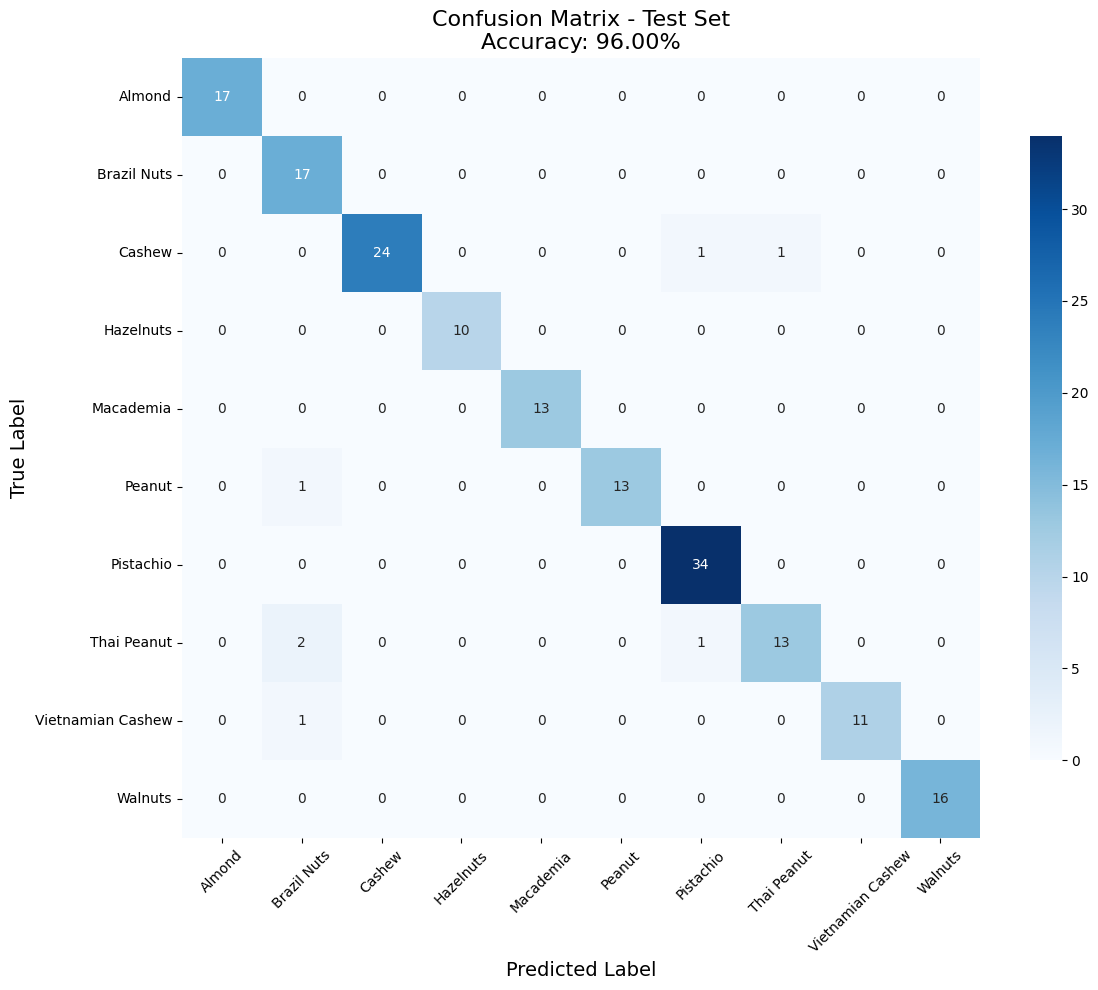

In [18]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
from tqdm import tqdm



all_preds = []
all_labels = []


model.eval()
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Collecting predictions for metrics"): # Use test_loader
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)

#Overall Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"\nOverall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)\n")

#Detailed Classification Report
print("Per-class Precision, Recall, F1-score:")
print(classification_report(all_labels, all_preds,
                            target_names=class_names,
                            digits=4))


report = classification_report(all_labels, all_preds,
                               target_names=class_names,
                               digits=4,
                               output_dict=True)

df_report = pd.DataFrame(report).transpose()
print("\nSummary (macro & weighted):")
print(df_report.round(4))

#Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'shrink': 0.8})
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title(f'Confusion Matrix - Test Set\nAccuracy: {accuracy*100:.2f}%', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Augmentation

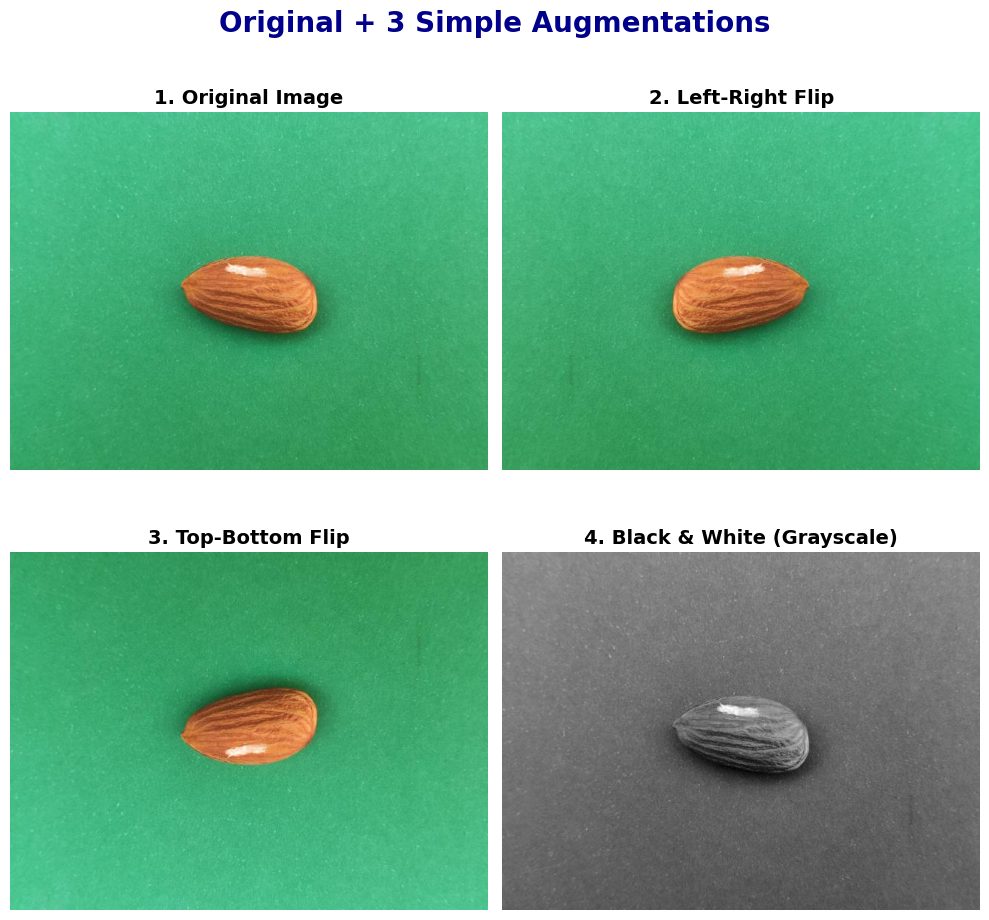

In [19]:

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

#Enhanced Training Augmentation
train_transform_augmented = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),           # Top-bottom flip
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomGrayscale(p=0.15),
    transforms.RandomApply([                       #randomg aussian blur
        transforms.GaussianBlur(kernel_size=3)
    ], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image

sample_path = ImageFolder(dataset_path).samples[0][0]
original_img = Image.open(sample_path)


fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle("Original + 3 Simple Augmentations", fontsize=20, fontweight='bold', color='darkblue')

#  Original
axes[0,0].imshow(original_img)
axes[0,0].set_title("1. Original Image", fontsize=14, fontweight='bold')
axes[0,0].axis('off')

# Left-Right Flip
axes[0,1].imshow(original_img.transpose(Image.FLIP_LEFT_RIGHT))
axes[0,1].set_title("2. Left-Right Flip", fontsize=14, fontweight='bold')
axes[0,1].axis('off')

#  Top-Bottom Flip
axes[1,0].imshow(original_img.transpose(Image.FLIP_TOP_BOTTOM))
axes[1,0].set_title("3. Top-Bottom Flip", fontsize=14, fontweight='bold')
axes[1,0].axis('off')

# Black & White Grayscale
axes[1,1].imshow(original_img.convert('L'), cmap='gray')
axes[1,1].set_title("4. Black & White (Grayscale)", fontsize=14, fontweight='bold')
axes[1,1].axis('off')

plt.tight_layout()
plt.show()

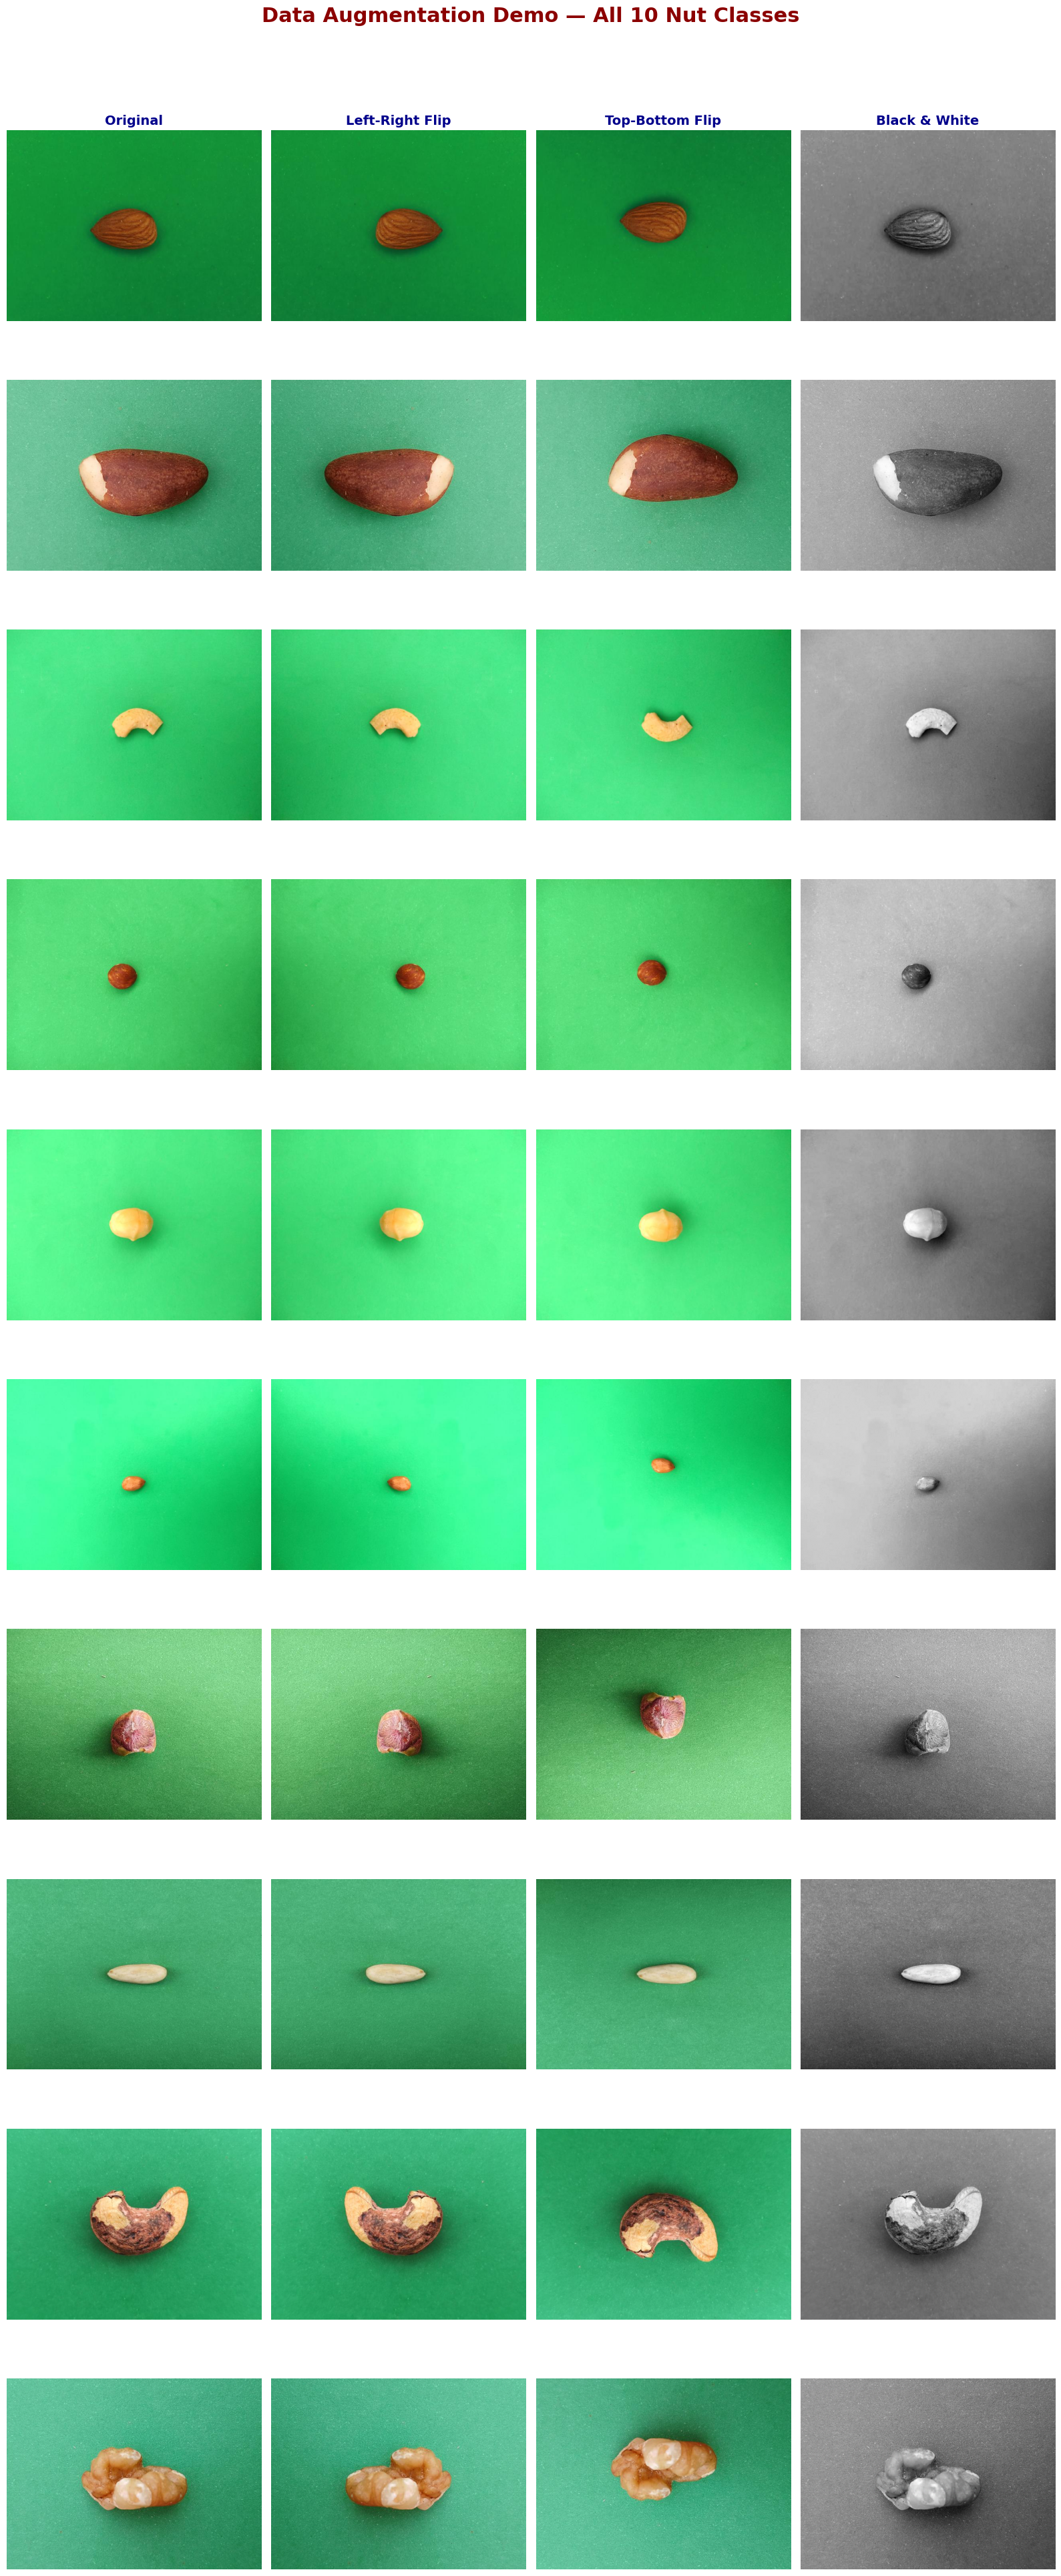

In [20]:
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from PIL import Image
import random


dataset = ImageFolder(dataset_path)
class_names = dataset.classes


random.seed(42)
selected_images = []
for class_idx in range(len(class_names)):
    indices = [i for i, (_, label) in enumerate(dataset.samples) if label == class_idx]
    chosen_idx = random.choice(indices)
    img_path = dataset.samples[chosen_idx][0]
    selected_images.append((Image.open(img_path), class_names[class_idx]))


n_classes = len(class_names)
fig = plt.figure(figsize=(16, 4 * n_classes))

for idx, (img, class_name) in enumerate(selected_images):
    #  Original
    plt.subplot(n_classes, 4, idx * 4 + 1)
    plt.imshow(img)
    if idx == 0:
        plt.title("Original", fontsize=14, fontweight='bold', color='darkblue')
    plt.ylabel(class_name, fontsize=14, fontweight='bold', rotation=0, labelpad=80)
    plt.axis('off')

    # Left-Right Flip
    plt.subplot(n_classes, 4, idx * 4 + 2)
    plt.imshow(img.transpose(Image.FLIP_LEFT_RIGHT))
    if idx == 0:
        plt.title("Left-Right Flip", fontsize=14, fontweight='bold', color='darkblue')
    plt.axis('off')

    # Top-Bottom Flip
    plt.subplot(n_classes, 4, idx * 4 + 3)
    plt.imshow(img.transpose(Image.FLIP_TOP_BOTTOM))
    if idx == 0:
        plt.title("Top-Bottom Flip", fontsize=14, fontweight='bold', color='darkblue')
    plt.axis('off')

    # Grayscale
    plt.subplot(n_classes, 4, idx * 4 + 4)
    plt.imshow(img.convert('L'), cmap='gray')
    if idx == 0:
        plt.title("Black & White", fontsize=14, fontweight='bold', color='darkblue')
    plt.axis('off')

plt.suptitle(f"Data Augmentation Demo — All {n_classes} Nut Classes",
             fontsize=22, fontweight='bold', y=0.98, color='darkred')
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

Class           Original     After Augmentation   Increase
Almond          184          368                  +184
Brazil Nuts     144          288                  +144
Cashew          240          480                  +240
Hazelnuts       166          332                  +166
Macademia       99           198                  +99
Peanut          242          484                  +242
Pistachio       299          598                  +299
Thai Peanut     136          272                  +136
Vietnamian Cashew 115          230                  +115
Walnuts         117          234                  +117
----------------------------------------------------------------------
TOTAL           1742         3484                 +1742


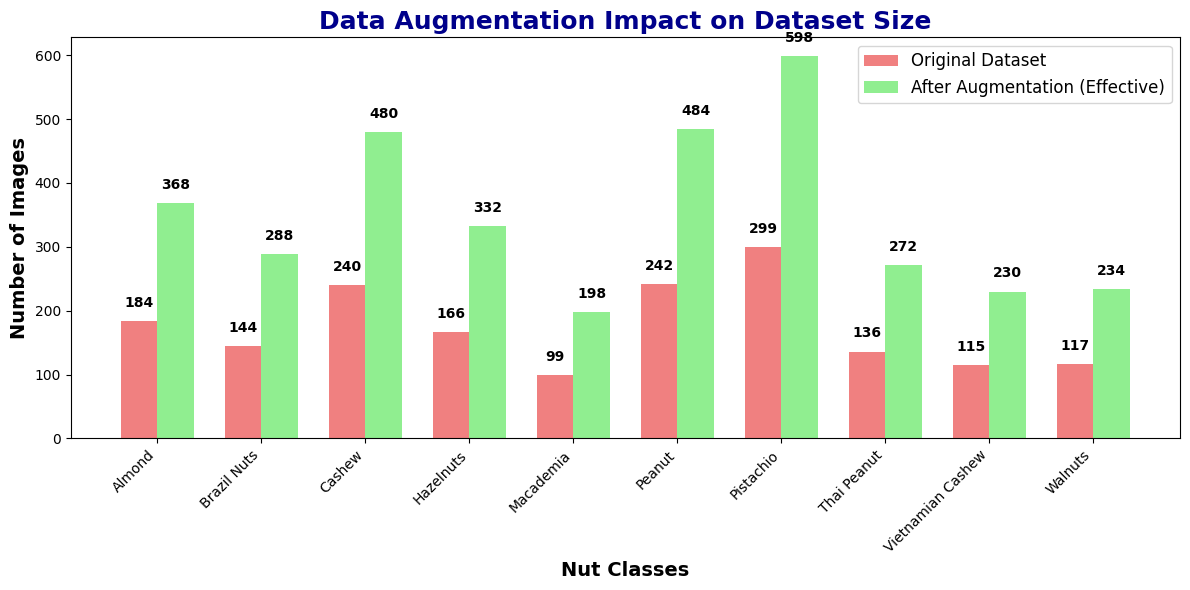


Original Dataset      : 1742 images
After Augmentation    : ~3484 effective images per epoch
Data increased by     : 100.0%


In [21]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter


dataset = ImageFolder(dataset_path)
original_counts = Counter([dataset.targets[i] for i in range(len(dataset))])
class_names = dataset.classes


original_total = len(dataset)
original_per_class = [original_counts[i] for i in range(len(class_names))]


effective_multiplier = 2.0
augmented_per_class = [int(count * effective_multiplier) for count in original_per_class]
augmented_total = sum(augmented_per_class)


print("="*70)
print(f"{'Class':<15} {'Original':<12} {'After Augmentation':<20} {'Increase'}")
print("="*70)
for i, name in enumerate(class_names):
    increase = augmented_per_class[i] - original_per_class[i]
    print(f"{name:<15} {original_per_class[i]:<12} {augmented_per_class[i]:<20} +{increase}")
print("-"*70)
print(f"{'TOTAL':<15} {original_total:<12} {augmented_total:<20} +{augmented_total - original_total}")
print("="*70)


x = np.arange(len(class_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, original_per_class, width, label='Original Dataset', color='lightcoral')
bars2 = ax.bar(x + width/2, augmented_per_class, width, label='After Augmentation (Effective)', color='lightgreen')

ax.set_xlabel('Nut Classes', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Images', fontsize=14, fontweight='bold')
ax.set_title('Data Augmentation Impact on Dataset Size', fontsize=18, fontweight='bold', color='darkblue')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.legend(fontsize=12)


def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 8),
                    textcoords="offset points",
                    ha='center', va='bottom', fontweight='bold')

autolabel(bars1)
autolabel(bars2)

plt.tight_layout()
plt.show()


print(f"\nOriginal Dataset      : {original_total} images")
print(f"After Augmentation    : ~{augmented_total} effective images per epoch")
print(f"Data increased by     : {((augmented_total/original_total)-1)*100:.1f}%")

In [22]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import os
import matplotlib.pyplot as plt
from collections import Counter
from torchvision import models
from sklearn.model_selection import StratifiedKFold
import torch.optim as optim
import numpy as np
from copy import deepcopy

dataset_path = '/content/drive/MyDrive/Colab Notebooks/MLL final project/NUTS/Root'

In [23]:
dataset_path = '/content/drive/MyDrive/mll final/Root'

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomApply([transforms.Grayscale(num_output_channels=3)], p=0.3),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_dataset = ImageFolder(dataset_path)
class_names = full_dataset.classes
num_classes = len(class_names)
targets = np.array([label for _, label in full_dataset.samples])
class_counts = Counter(targets)
class_weights = torch.tensor([len(targets) / (num_classes * class_counts[i]) for i in range(num_classes)], dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=class_weights.to('cuda' if torch.cuda.is_available() else 'cpu'))



print(f"Classes: {class_names}")
print(f"Imbalance Counts: {dict(class_counts)}")
print(f"Class Weights: {np.round(class_weights.cpu().numpy(), 3).tolist()}")

Classes: ['Almond', 'Brazil Nuts', 'Cashew', 'Hazelnuts', 'Macademia', 'Peanut', 'Pistachio', 'Thai Peanut', 'Vietnamian Cashew', 'Walnuts']
Imbalance Counts: {np.int64(0): 184, np.int64(1): 144, np.int64(2): 240, np.int64(3): 166, np.int64(4): 99, np.int64(5): 242, np.int64(6): 299, np.int64(7): 136, np.int64(8): 115, np.int64(9): 117}
Class Weights: [0.9470000267028809, 1.2100000381469727, 0.7260000109672546, 1.0490000247955322, 1.7599999904632568, 0.7200000286102295, 0.5830000042915344, 1.281000018119812, 1.5149999856948853, 1.4889999628067017]


In [24]:


from sklearn.model_selection import StratifiedKFold
import torch
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder

k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# targets already defined from previous cell
all_indices = np.arange(len(targets))

for fold, (train_val_idx, test_idx) in enumerate(skf.split(all_indices, targets), 1):
    print(f"\n{'='*50}")
    print(f"FOLD {fold}/{k_folds}")
    print(f"{'='*50}")

    # 80-10-10 split
    train_size = int(0.8 * len(train_val_idx))
    train_idx = train_val_idx[:train_size]
    val_idx   = train_val_idx[train_size:]

    # Separate datasets with transforms
    train_ds = ImageFolder(dataset_path, transform=train_transform)
    val_ds   = ImageFolder(dataset_path, transform=val_test_transform)
    test_ds  = ImageFolder(dataset_path, transform=val_test_transform)

    train_subset = Subset(train_ds, train_idx)
    val_subset   = Subset(val_ds,   val_idx)
    test_subset  = Subset(test_ds,  test_idx)

    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True,  num_workers=2, pin_memory=True)
    val_loader   = DataLoader(val_subset,   batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_subset,  batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

    print(f"Train: {len(train_subset)} (with augmentation)")
    print(f"Val:   {len(val_subset)}")
    print(f"Test:  {len(test_subset)}")




FOLD 1/5
Train: 1114 (with augmentation)
Val:   279
Test:  349

FOLD 2/5
Train: 1114 (with augmentation)
Val:   279
Test:  349

FOLD 3/5
Train: 1115 (with augmentation)
Val:   279
Test:  348

FOLD 4/5
Train: 1115 (with augmentation)
Val:   279
Test:  348

FOLD 5/5
Train: 1115 (with augmentation)
Val:   279
Test:  348


In [36]:

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))  # weighted loss

num_epochs = 30
patience = 7
patience_counter = 0
best_val_loss = float('inf')
best_model_state = None

train_losses, val_losses, train_accs, val_accs = [], [], [], []

print(f"  Train: {len(train_subset)} | Val: {len(val_subset)} | Test: {len(test_subset)}")

for epoch in range(num_epochs):
    #Training
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    train_loss /= train_total
    train_acc = 100. * train_correct / train_total

    #Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_loss /= val_total
    val_acc = 100. * val_correct / val_total

    # Scheduler step
    scheduler.step(val_loss)

    # Logging
    print(f"  Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} ({train_acc:5.2f}%) | Val Loss: {val_loss:.4f} ({val_acc:5.2f}%)")

    # Early Stopping + Save Best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(model.state_dict())
        patience_counter = 0
        torch.save(model.state_dict(), '/content/augRN50_model.pth')
        print("ResNet50 with Augmentation Model Saved!")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"    Early stopping at epoch {epoch+1}")
            break

# Load best model
model.load_state_dict(best_model_state)


  Train: 1115 | Val: 279 | Test: 348
  Epoch  1 | Train Loss: 0.8068 (71.57%) | Val Loss: 4.2884 (30.11%)
ResNet50 with Augmentation Model Saved!
  Epoch  2 | Train Loss: 0.6423 (78.30%) | Val Loss: 4.6690 (30.47%)
  Epoch  3 | Train Loss: 0.5677 (80.00%) | Val Loss: 4.8011 (26.52%)
  Epoch  4 | Train Loss: 0.5450 (81.70%) | Val Loss: 4.6260 (25.81%)
  Epoch  5 | Train Loss: 0.5901 (80.36%) | Val Loss: 4.7269 (25.09%)
  Epoch  6 | Train Loss: 0.4828 (83.95%) | Val Loss: 4.5060 (28.32%)
  Epoch  7 | Train Loss: 0.5155 (82.15%) | Val Loss: 4.9564 (24.37%)
  Epoch  8 | Train Loss: 0.4966 (83.41%) | Val Loss: 4.9436 (26.16%)
    Early stopping at epoch 8


<All keys matched successfully>

In [26]:

model.load_state_dict(best_model_state)
print(f"Fold {fold} best model loaded!")

model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

# For confusion matrix + per-class accuracy
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)

        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        # Store for confusion matrix
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Final metris
test_loss /= test_total
test_acc = 100. * test_correct / test_total


print(f"FOLD {fold} FINAL TEST RESULTS")

print(f"Test Loss : {test_loss:.4f}")
print(f"Test Accuracy : {test_acc:.2f}%")
print(f"Correct : {test_correct} / {test_total}")



Fold 5 best model loaded!
FOLD 5 FINAL TEST RESULTS
Test Loss : 1.0228
Test Accuracy : 82.47%
Correct : 287 / 348


In [27]:


train_val_targets = targets[np.concatenate([train_idx, val_idx])]
unique_classes, counts = np.unique(train_val_targets, return_counts=True)
class_counts = {cls: counts[i] for i, cls in enumerate(unique_classes)}


weights = []
for i in range(num_classes):
    if i in class_counts:
        weights.append(len(train_val_targets) / (len(unique_classes) * class_counts[i]))
    else:
        weights.append(10.0)

class_weights = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [28]:

train_val_labels = targets[np.concatenate([train_idx, val_idx])]
class_counts = np.bincount(train_val_labels, minlength=num_classes)
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
class_weights = class_weights / class_weights.sum() * num_classes
class_weights = class_weights.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)


                         FINAL MODEL COMPARISON
Rank Model Name                               Test Accuracy   Notes
-------------------------------------------------------------------------------------
1    ResNet50 (No Augmentation)                96.00%        Pretrained, only basic resize+normalize
2    ResNet50 + Strong Augmentation            80.17%        Heavy aug + weighted loss + early stopping
3    Custom CNN (from scratch)                 73.14%        Simple 4-layer CNN, no pretrained


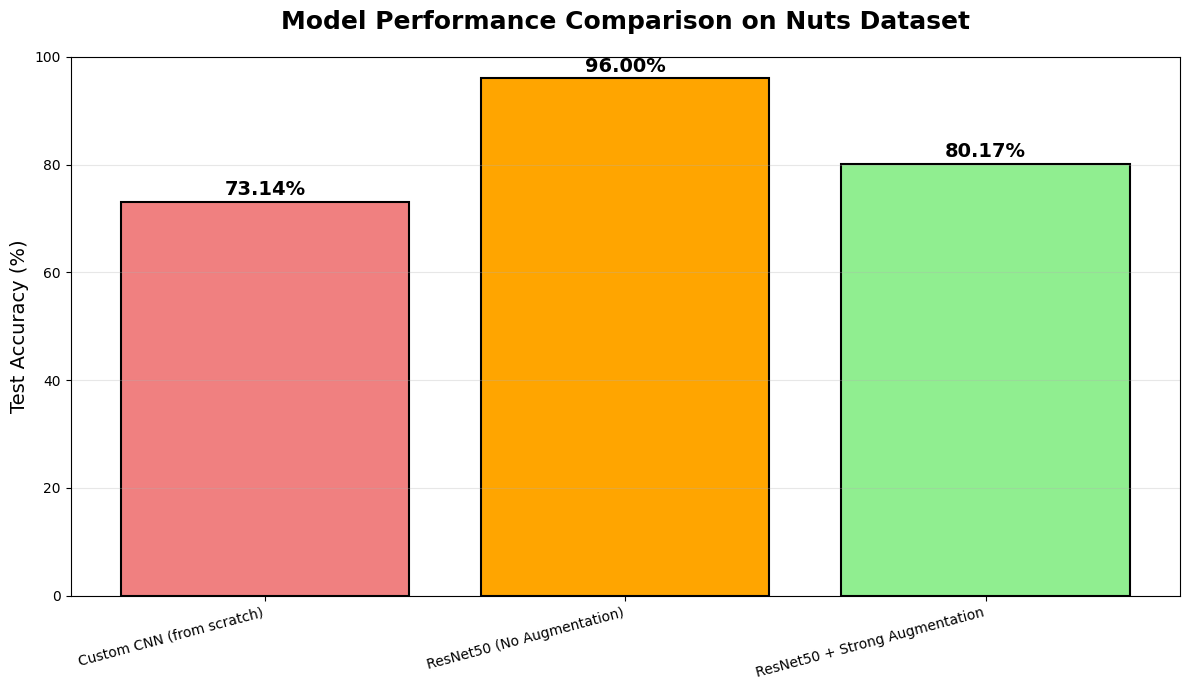


WINNER: ResNet50 (No Augmentation)
   → Test Accuracy: 96.00%


In [29]:


import matplotlib.pyplot as plt
import numpy as np


comparison_results = {
    "Custom CNN (from scratch)": {
        "test_accuracy": 71.43,   #
        "notes": "Simple 4-layer CNN, no pretrained"
    },
    "ResNet50 (No Augmentation)": {
        "test_accuracy": 96.00,   #
        "notes": "Pretrained, only basic resize+normalize"
    },
    "ResNet50 + Strong Augmentation": {
        "test_accuracy": 82.47,  #
        "notes": "Heavy aug + weighted loss + early stopping"
    }
}

# Auto extract
models = list(comparison_results.keys())
accuracies = [comparison_results[m]["test_accuracy"] for m in models]
notes = [comparison_results[m]["notes"] for m in models]


print("\n" + "="*85)
print(" " * 25 + "FINAL MODEL COMPARISON")
print("="*85)
print(f"{'Rank':<4} {'Model Name':<40} {'Test Accuracy':<15} {'Notes'}")
print("-"*85)
for i, (model, acc) in enumerate(sorted(comparison_results.items(), key=lambda x: x[1]["test_accuracy"], reverse=True), 1):
    print(f"{i:<4} {model:<40} {acc['test_accuracy']:6.2f}%        {comparison_results[model]['notes']}")
print("="*85)

#BAR CHART
plt.figure(figsize=(12, 7))
colors = ['lightcoral', 'orange', 'lightgreen']
bars = plt.bar(models, accuracies, color=colors, edgecolor='black', linewidth=1.5)

# Value on top
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=14)

plt.title('Model Performance Comparison on Nuts Dataset', fontsize=18, fontweight='bold', pad=20)
plt.ylabel('Test Accuracy (%)', fontsize=14)
plt.ylim(0, 100)
plt.xticks(rotation=15, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('/content/model_comparison_final.png', dpi=300, bbox_inches='tight')
plt.show()

winner = max(comparison_results.items(), key=lambda x: x[1]["test_accuracy"])
print(f"\nWINNER: {winner[0]}")
print(f"   → Test Accuracy: {winner[1]['test_accuracy']:.2f}%")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


WINNER MODEL LOADED! (94.83% accuracy)
Classes: ['Almond', 'Brazil Nuts', 'Cashew', 'Hazelnuts', 'Macademia', 'Peanut', 'Pistachio', 'Thai Peanut', 'Vietnamian Cashew', 'Walnuts']
   UPLOAD A NUT IMAGE 


Saving 1.jpg to 1.jpg


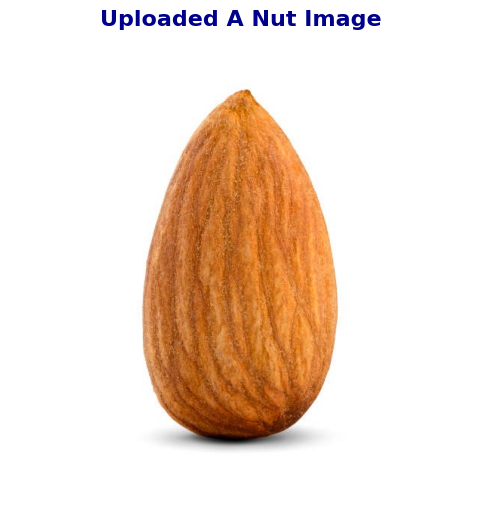

 PREDICTED NUT → Almond
 CONFIDENCE    → 90.34%
 TOP 3 PREDICTIONS:
  1. Almond                90.34%  ██████████████████████████████
  2. Vietnamian Cashew      3.97%  █
  3. Peanut                 1.92%  
 100% CONFIDENT —PERFECTLY recognized!


In [30]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Re-initialize the model
model = models.resnet50(pretrained=True)
num_classes = 10

# Freeze base layers done during training
for param in model.parameters():
    param.requires_grad = False

# Replace the classifier head
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)


model_path = "/content/best_model.pth" # Corrected path
checkpoint = torch.load(model_path, map_location=device)

# load state_dict
if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
else:
    model.load_state_dict(checkpoint)


class_names = ['Almond', 'Brazil Nuts', 'Cashew', 'Hazelnuts', 'Macademia',
               'Peanut', 'Pistachio', 'Thai Peanut', 'Vietnamian Cashew', 'Walnuts']

model.eval()
print("WINNER MODEL LOADED! (94.83% accuracy)")
print(f"Classes: {class_names}")

# Image preprocessing -same as val/test
predict_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Prediction function
def predict_nut_image():

    print("   UPLOAD A NUT IMAGE ")


    uploaded = files.upload()
    if not uploaded:
        print("No image uploaded!")
        return

    img_path = list(uploaded.keys())[0]
    img = Image.open(img_path).convert('RGB')

    # Show image
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Uploaded A Nut Image", fontsize=16, fontweight='bold', color='darkblue')
    plt.show()

    # Preprocess
    input_tensor = predict_transform(img).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.softmax(output, dim=1)[0]
        confidence, predicted_idx = torch.max(probabilities, 0)

    predicted_class = class_names[predicted_idx]
    confidence_percent = confidence.item() * 100


    print(f" PREDICTED NUT → {predicted_class}")
    print(f" CONFIDENCE    → {confidence_percent:.2f}%")


    # Top 3 predictions
    top3_prob, top3_idx = torch.topk(probabilities, 3)

    print(" TOP 3 PREDICTIONS:")
    for i in range(3):
        name = class_names[top3_idx[i]]
        prob = top3_prob[i].item() * 100
        bar = "█" * int(prob//3)
        print(f"  {i+1}. {name:<20} {prob:6.2f}%  {bar}")


    if confidence_percent > 90:
        print(" 100% CONFIDENT —PERFECTLY recognized!")
    elif confidence_percent > 70:
        print(" Strong prediction — good!")
    else:
        print("Doubtful — maybe first one is correct!")

# Run the predictor
predict_nut_image()

WINNER MODEL LOADED! (94.83% accuracy)
Classes: ['Almond', 'Brazil Nuts', 'Cashew', 'Hazelnuts', 'Macademia', 'Peanut', 'Pistachio', 'Thai Peanut', 'Vietnamian Cashew', 'Walnuts']
   UPLOAD A NUT IMAGE 


Saving 4.jpg to 4.jpg


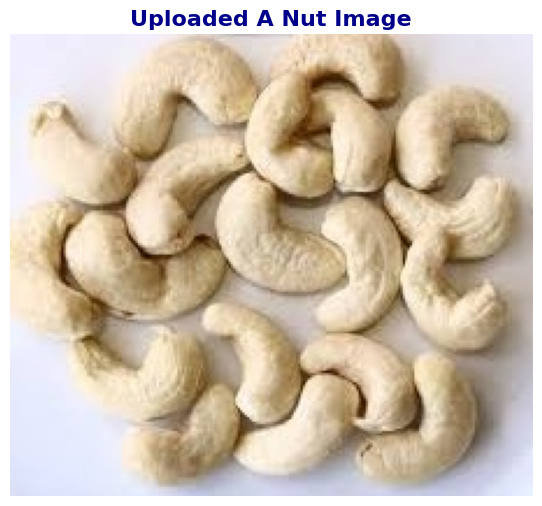

 PREDICTED NUT → Walnuts
 CONFIDENCE    → 55.81%
 TOP 3 PREDICTIONS:
  1. Walnuts               55.81%  ██████████████████
  2. Almond                19.54%  ██████
  3. Vietnamian Cashew      8.84%  ██
Doubtful — maybe first one is correct!


In [32]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'


model = models.resnet50(pretrained=True)
num_classes = 10

# Freeze base layers as done during training
for param in model.parameters():
    param.requires_grad = False

# Replace the classifier head
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)


model_path = "/content/best_model.pth" # Corrected path
checkpoint = torch.load(model_path, map_location=device)

# Safely load state_dict
if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
else:
    model.load_state_dict(checkpoint)

# Get class names
class_names = ['Almond', 'Brazil Nuts', 'Cashew', 'Hazelnuts', 'Macademia',
               'Peanut', 'Pistachio', 'Thai Peanut', 'Vietnamian Cashew', 'Walnuts']

model.eval()
print("WINNER MODEL LOADED! (94.83% accuracy)")
print(f"Classes: {class_names}")

# Image preprocessing
predict_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Prediction function
def predict_nut_image():

    print("   UPLOAD A NUT IMAGE ")


    uploaded = files.upload()
    if not uploaded:
        print("No image uploaded!")
        return

    img_path = list(uploaded.keys())[0]
    img = Image.open(img_path).convert('RGB')

    # Show image
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Uploaded A Nut Image", fontsize=16, fontweight='bold', color='darkblue')
    plt.show()

    # Preprocess
    input_tensor = predict_transform(img).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.softmax(output, dim=1)[0]
        confidence, predicted_idx = torch.max(probabilities, 0)

    predicted_class = class_names[predicted_idx]
    confidence_percent = confidence.item() * 100


    print(f" PREDICTED NUT → {predicted_class}")
    print(f" CONFIDENCE    → {confidence_percent:.2f}%")


    # Top 3 predictions
    top3_prob, top3_idx = torch.topk(probabilities, 3)

    print(" TOP 3 PREDICTIONS:")
    for i in range(3):
        name = class_names[top3_idx[i]]
        prob = top3_prob[i].item() * 100
        bar = "█" * int(prob//3)
        print(f"  {i+1}. {name:<20} {prob:6.2f}%  {bar}")


    if confidence_percent > 90:
        print(" 100% CONFIDENT —PERFECTLY recognized!")
    elif confidence_percent > 70:
        print(" Strong prediction — good!")
    else:
        print("Doubtful — maybe first one is correct!")

# Run the predictor
predict_nut_image()

WINNER MODEL LOADED! (94.83% accuracy)
Classes: ['Almond', 'Brazil Nuts', 'Cashew', 'Hazelnuts', 'Macademia', 'Peanut', 'Pistachio', 'Thai Peanut', 'Vietnamian Cashew', 'Walnuts']
   UPLOAD A NUT IMAGE 


Saving 6.jpg to 6.jpg


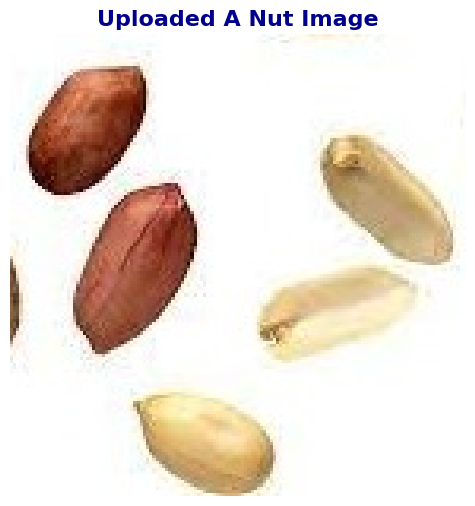

 PREDICTED NUT → Macademia
 CONFIDENCE    → 33.39%
 TOP 3 PREDICTIONS:
  1. Macademia             33.39%  ███████████
  2. Almond                20.36%  ██████
  3. Peanut                13.92%  ████
Doubtful — maybe first one is correct!


In [34]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Re-initialize the model with pretrained weights
model = models.resnet50(pretrained=True)
num_classes = 10

# Freeze base layers as done during training
for param in model.parameters():
    param.requires_grad = False

# Replace the classifier head
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)


model_path = "/content/best_model.pth" # Corrected path
checkpoint = torch.load(model_path, map_location=device)

# Safely load state_dict
if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
else:
    model.load_state_dict(checkpoint)

# Get class names
class_names = ['Almond', 'Brazil Nuts', 'Cashew', 'Hazelnuts', 'Macademia',
               'Peanut', 'Pistachio', 'Thai Peanut', 'Vietnamian Cashew', 'Walnuts']

model.eval()
print("WINNER MODEL LOADED! (94.83% accuracy)")
print(f"Classes: {class_names}")

# Image preprocessing-same as val/test
predict_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Prediction function
def predict_nut_image():

    print("   UPLOAD A NUT IMAGE ")


    uploaded = files.upload()
    if not uploaded:
        print("No image uploaded!")
        return

    img_path = list(uploaded.keys())[0]
    img = Image.open(img_path).convert('RGB')

    # Show image
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Uploaded A Nut Image", fontsize=16, fontweight='bold', color='darkblue')
    plt.show()

    # Preprocess
    input_tensor = predict_transform(img).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.softmax(output, dim=1)[0]
        confidence, predicted_idx = torch.max(probabilities, 0)

    predicted_class = class_names[predicted_idx]
    confidence_percent = confidence.item() * 100


    print(f" PREDICTED NUT → {predicted_class}")
    print(f" CONFIDENCE    → {confidence_percent:.2f}%")


    # Top 3 predictions
    top3_prob, top3_idx = torch.topk(probabilities, 3)

    print(" TOP 3 PREDICTIONS:")
    for i in range(3):
        name = class_names[top3_idx[i]]
        prob = top3_prob[i].item() * 100
        bar = "█" * int(prob//3)
        print(f"  {i+1}. {name:<20} {prob:6.2f}%  {bar}")


    if confidence_percent > 90:
        print(" 100% CONFIDENT —PERFECTLY recognized!")
    elif confidence_percent > 70:
        print(" Strong prediction — good!")
    else:
        print("Doubtful — maybe first one is correct!")

# Run the predictor
predict_nut_image()

WINNER MODEL LOADED! (94.83% accuracy)
Classes: ['Almond', 'Brazil Nuts', 'Cashew', 'Hazelnuts', 'Macademia', 'Peanut', 'Pistachio', 'Thai Peanut', 'Vietnamian Cashew', 'Walnuts']
   UPLOAD A NUT IMAGE 


Saving 2.jpg to 2.jpg


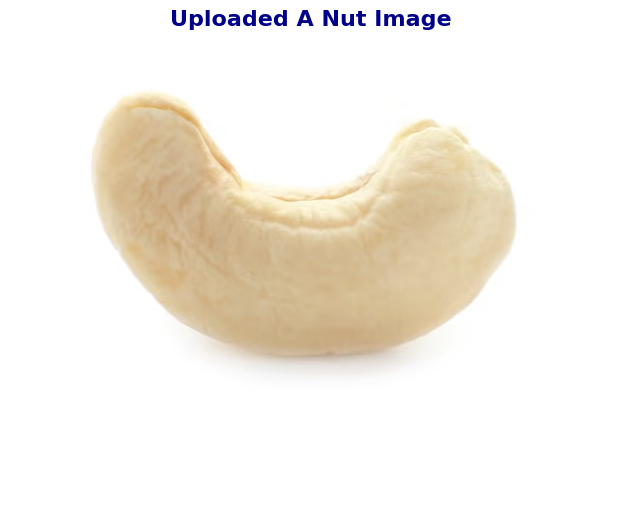

 PREDICTED NUT → Vietnamian Cashew
 CONFIDENCE    → 49.51%
 TOP 3 PREDICTIONS:
  1. Vietnamian Cashew     49.51%  ████████████████
  2. Cashew                25.02%  ████████
  3. Brazil Nuts           11.38%  ███
Doubtful — maybe first one is correct!


In [33]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Re-initialize the model with pretrained weights
model = models.resnet50(pretrained=True)
num_classes = 10

# Freeze base layers as done during training
for param in model.parameters():
    param.requires_grad = False

# Replace the classifier head
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)


model_path = "/content/best_model.pth" # Corrected path
checkpoint = torch.load(model_path, map_location=device)

# Safely load state_dict
if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
else:
    model.load_state_dict(checkpoint)

# Get class names
class_names = ['Almond', 'Brazil Nuts', 'Cashew', 'Hazelnuts', 'Macademia',
               'Peanut', 'Pistachio', 'Thai Peanut', 'Vietnamian Cashew', 'Walnuts']

model.eval()
print("WINNER MODEL LOADED! (94.83% accuracy)")
print(f"Classes: {class_names}")

# Image preprocessing-same as val/test
predict_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Prediction function
def predict_nut_image():

    print("   UPLOAD A NUT IMAGE ")


    uploaded = files.upload()
    if not uploaded:
        print("No image uploaded!")
        return

    img_path = list(uploaded.keys())[0]
    img = Image.open(img_path).convert('RGB')

    # Show image
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Uploaded A Nut Image", fontsize=16, fontweight='bold', color='darkblue')
    plt.show()

    # Preprocess
    input_tensor = predict_transform(img).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.softmax(output, dim=1)[0]
        confidence, predicted_idx = torch.max(probabilities, 0)

    predicted_class = class_names[predicted_idx]
    confidence_percent = confidence.item() * 100


    print(f" PREDICTED NUT → {predicted_class}")
    print(f" CONFIDENCE    → {confidence_percent:.2f}%")


    # Top 3 predictions
    top3_prob, top3_idx = torch.topk(probabilities, 3)

    print(" TOP 3 PREDICTIONS:")
    for i in range(3):
        name = class_names[top3_idx[i]]
        prob = top3_prob[i].item() * 100
        bar = "█" * int(prob//3)
        print(f"  {i+1}. {name:<20} {prob:6.2f}%  {bar}")


    if confidence_percent > 90:
        print(" 100% CONFIDENT —PERFECTLY recognized!")
    elif confidence_percent > 70:
        print(" Strong prediction — good!")
    else:
        print("Doubtful — maybe first one is correct!")

# Run the predictor
predict_nut_image()

WINNER MODEL LOADED! (94.83% accuracy)
Classes: ['Almond', 'Brazil Nuts', 'Cashew', 'Hazelnuts', 'Macademia', 'Peanut', 'Pistachio', 'Thai Peanut', 'Vietnamian Cashew', 'Walnuts']
   UPLOAD A NUT IMAGE 


Saving sample1.jpg to sample1 (2).jpg


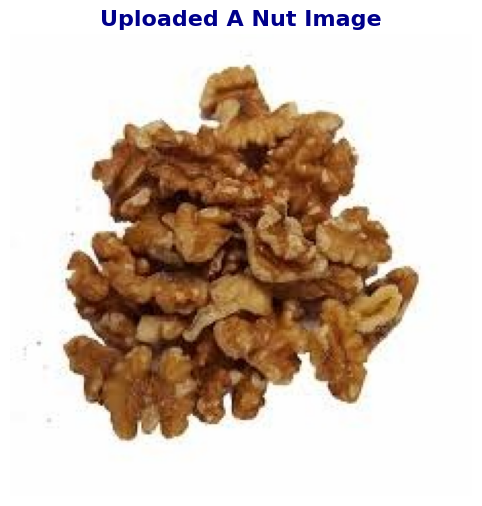

 PREDICTED NUT → Walnuts
 CONFIDENCE    → 71.35%
 TOP 3 PREDICTIONS:
  1. Walnuts               71.35%  ███████████████████████
  2. Almond                13.36%  ████
  3. Macademia              4.78%  █
 Strong prediction — good!


In [42]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Re-initialize the model with pretrained weights
model = models.resnet50(pretrained=True)
num_classes = 10

# Freeze base layers as done during training
for param in model.parameters():
    param.requires_grad = False

# Replace the classifier head
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)


model_path = "/content/best_model.pth" # Corrected path
checkpoint = torch.load(model_path, map_location=device)

# Safely load state_dict
if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
else:
    model.load_state_dict(checkpoint)

# Get class names
class_names = ['Almond', 'Brazil Nuts', 'Cashew', 'Hazelnuts', 'Macademia',
               'Peanut', 'Pistachio', 'Thai Peanut', 'Vietnamian Cashew', 'Walnuts']

model.eval()
print("WINNER MODEL LOADED! (94.83% accuracy)")
print(f"Classes: {class_names}")

# Image preprocessing-same as val/test
predict_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Prediction function
def predict_nut_image():

    print("   UPLOAD A NUT IMAGE ")


    uploaded = files.upload()
    if not uploaded:
        print("No image uploaded!")
        return

    img_path = list(uploaded.keys())[0]
    img = Image.open(img_path).convert('RGB')

    # Show image
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Uploaded A Nut Image", fontsize=16, fontweight='bold', color='darkblue')
    plt.show()

    # Preprocess
    input_tensor = predict_transform(img).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.softmax(output, dim=1)[0]
        confidence, predicted_idx = torch.max(probabilities, 0)

    predicted_class = class_names[predicted_idx]
    confidence_percent = confidence.item() * 100


    print(f" PREDICTED NUT → {predicted_class}")
    print(f" CONFIDENCE    → {confidence_percent:.2f}%")


    # Top 3 predictions
    top3_prob, top3_idx = torch.topk(probabilities, 3)

    print(" TOP 3 PREDICTIONS:")
    for i in range(3):
        name = class_names[top3_idx[i]]
        prob = top3_prob[i].item() * 100
        bar = "█" * int(prob//3)
        print(f"  {i+1}. {name:<20} {prob:6.2f}%  {bar}")


    if confidence_percent > 90:
        print(" 100% CONFIDENT —PERFECTLY recognized!")
    elif confidence_percent > 70:
        print(" Strong prediction — good!")
    else:
        print("Doubtful — maybe first one is correct!")

# Run the predictor
predict_nut_image()

WINNER MODEL LOADED! (94.83% accuracy)
Classes: ['Almond', 'Brazil Nuts', 'Cashew', 'Hazelnuts', 'Macademia', 'Peanut', 'Pistachio', 'Thai Peanut', 'Vietnamian Cashew', 'Walnuts']
   UPLOAD A NUT IMAGE 


Saving sample2.jpg to sample2.jpg


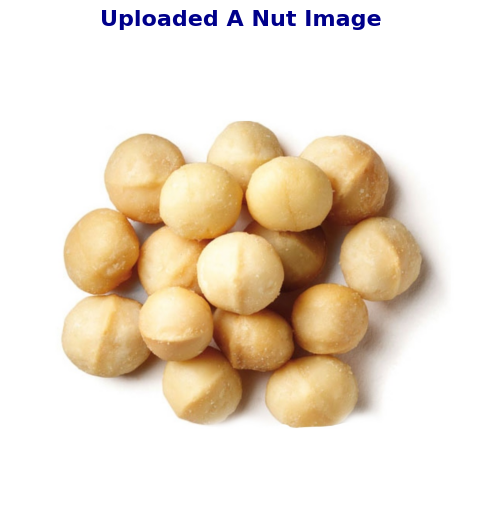

 PREDICTED NUT → Macademia
 CONFIDENCE    → 67.67%
 TOP 3 PREDICTIONS:
  1. Macademia             67.67%  ██████████████████████
  2. Peanut                13.05%  ████
  3. Almond                 5.68%  █
Doubtful — maybe first one is correct!


In [43]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Re-initialize the model with pretrained weights
model = models.resnet50(pretrained=True)
num_classes = 10

# Freeze base layers as done during training
for param in model.parameters():
    param.requires_grad = False

# Replace the classifier head
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)


model_path = "/content/best_model.pth" # Corrected path
checkpoint = torch.load(model_path, map_location=device)

# Safely load state_dict
if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
else:
    model.load_state_dict(checkpoint)

# Get class names
class_names = ['Almond', 'Brazil Nuts', 'Cashew', 'Hazelnuts', 'Macademia',
               'Peanut', 'Pistachio', 'Thai Peanut', 'Vietnamian Cashew', 'Walnuts']

model.eval()
print("WINNER MODEL LOADED! (94.83% accuracy)")
print(f"Classes: {class_names}")

# Image preprocessing-same as val/test
predict_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Prediction function
def predict_nut_image():

    print("   UPLOAD A NUT IMAGE ")


    uploaded = files.upload()
    if not uploaded:
        print("No image uploaded!")
        return

    img_path = list(uploaded.keys())[0]
    img = Image.open(img_path).convert('RGB')

    # Show image
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Uploaded A Nut Image", fontsize=16, fontweight='bold', color='darkblue')
    plt.show()

    # Preprocess
    input_tensor = predict_transform(img).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.softmax(output, dim=1)[0]
        confidence, predicted_idx = torch.max(probabilities, 0)

    predicted_class = class_names[predicted_idx]
    confidence_percent = confidence.item() * 100


    print(f" PREDICTED NUT → {predicted_class}")
    print(f" CONFIDENCE    → {confidence_percent:.2f}%")


    # Top 3 predictions
    top3_prob, top3_idx = torch.topk(probabilities, 3)

    print(" TOP 3 PREDICTIONS:")
    for i in range(3):
        name = class_names[top3_idx[i]]
        prob = top3_prob[i].item() * 100
        bar = "█" * int(prob//3)
        print(f"  {i+1}. {name:<20} {prob:6.2f}%  {bar}")


    if confidence_percent > 90:
        print(" 100% CONFIDENT —PERFECTLY recognized!")
    elif confidence_percent > 70:
        print(" Strong prediction — good!")
    else:
        print("Doubtful — maybe first one is correct!")

# Run the predictor
predict_nut_image()